In [1]:
import librosa as lr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def filter_audio(audio):
    # Считаем энергию голоса для каждого блока в 125 мс
    apower = lr.amplitude_to_db(np.abs(lr.stft(audio, n_fft=2048)), ref=np.max)

    # Суммируем энергию по каждой частоте, нормализуем
    apsums = np.sum(apower, axis=0)**2
    apsums -= np.min(apsums)
    apsums /= np.max(apsums)

    # Сглаживаем график, чтобы сохранить короткие пропуски и паузы, убрать резкость
    apsums = np.convolve(apsums, np.ones((9,)), 'same')
    # Нормализуем снова
    apsums -= np.min(apsums)
    apsums /= np.max(apsums)

    # Устанавливаем порог в 35% шума над голосом
    apsums = np.array(apsums > 0.35, dtype=bool)

    # Удлиняем блоки каждый по 125 мс
    # до отдельных семплов (2048 в блоке)
    apsums = np.repeat(apsums, np.ceil(len(audio) / len(apsums)))[:len(audio)]

    return audio[apsums] # Фильтруем!

In [3]:
#SR = 44100 # Частота дискретизации

def process_audio(aname):
    #audio, _ = lr.load(aname, sr=SR) # Загружаем трек в память
    audio, Sr = lr.load(aname, sr=None) # Загружаем трек в память
    print(Sr)
    audio = filter_audio(audio) # Убираем тишину и пробелы между словами
    # Извлекаем коэффициенты
    afs = lr.feature.mfcc(audio, # из нашего звука
                          sr=Sr, # с частотой дискретизации 16 кГц
                          n_mfcc=34, # Извлекаем 34 параметра
                          n_fft=2048) # Используем блоки в 125 мс
    # Суммируем все коэффициенты по времени
    # Отбрасываем два первых, так как они не слышны человеку и содержат шум
    afss = np.sum(afs[2:], axis=-1)

    # Нормализуем их
    afss = afss / np.max(np.abs(afss))

    return afss

def confidence(x, y):
    return np.sqrt(np.sum((x - y)**2)) # Евклидово расстояние (меньше — лучше)

In [4]:
## Загружаем несколько аудиодорожек
# test11 = process_audio("test11.wav")
# test12 = process_audio("test12.wav")
# test21 = process_audio("test21.wav")
# test22 = process_audio("test22.wav")

test1 = process_audio("16000_1.wav")
test2 = process_audio("16000_2.wav")
test3 = process_audio("16000_3.wav")
test4 = process_audio("16000_4.wav")
test5 = process_audio("16000_5.wav")
test6 = process_audio("16000_6.wav")
test7 = process_audio("16000_7.wav")

16000
16000
16000
16000
16000
16000
16000


In [5]:
## Сравниваем коэффициенты на близость
print('same1', confidence(test1, test2))
print('same2', confidence(test3, test4))
print('same3', confidence(test5, test6))
print('same4', confidence(test6, test7))
print('diff1', confidence(test1, test3))
print('diff2', confidence(test2, test4))
print('diff3', confidence(test1, test5))
print('diff4', confidence(test4, test6))
print('diff5', confidence(test1, test7))

same1 1.0697043
same2 1.0246837
same3 1.1958925
same4 1.8220456
diff1 2.3684902
diff2 1.8360323
diff3 2.0715578
diff4 2.1171117
diff5 2.0583944


In [6]:
test1

array([-0.1674524 ,  1.        , -0.560122  ,  0.31387937, -0.38923317,
       -0.85326225, -0.46589646, -0.48746967, -0.2936009 , -0.14852324,
       -0.1467632 ,  0.01809999,  0.06610896, -0.13608904, -0.3731906 ,
        0.07376593, -0.5947444 , -0.19522469, -0.22893323, -0.36536238,
       -0.17124029, -0.08557007, -0.01849566, -0.00104861, -0.16466667,
       -0.07252201, -0.12402327, -0.20193021, -0.15861431, -0.06821901,
       -0.15594853, -0.22790036], dtype=float32)

In [7]:
t = np.linspace(0, 31, 32, dtype=int)
gr1 = test1[t]
gr2 = test2[t]
zh1 = test3[t]
zh2 = test4[t]
el1 = test5[t]
el2 = test6[t]
el3 = test7[t]

In [8]:
df = pd.DataFrame()
df['t'] = t
df['gr1'] = gr1
df['gr2'] = gr2
df['zh1'] = zh1
df['zh2'] = zh2
df['el1'] = el1
df['el2'] = el2
df['el3'] = el3
df.head(5)

,t,gr1,gr2,zh1,zh2,el1,el2,el3
0,0,-0.167452,0.048465,0.598285,1.000000,-1.000000,-0.446911,1.000000
1,1,1.000000,1.000000,0.106907,0.211763,0.742702,1.000000,0.671917
2,2,-0.560122,-0.142251,-0.544547,0.036795,0.352799,0.201922,-0.228024
3,3,0.313879,-0.070399,-0.201294,-0.200858,0.581103,-0.015579,-0.064519
4,4,-0.389233,-0.168883,-0.119225,-0.088296,-0.616622,-0.394547,-0.123132


In [9]:
df['gr_mean'] = (df['gr1'] + df['gr2'])/2
df['zh_mean'] = (df['zh1'] + df['zh2'])/2
df['el_mean'] = (df['el1'] + df['el2'])/2

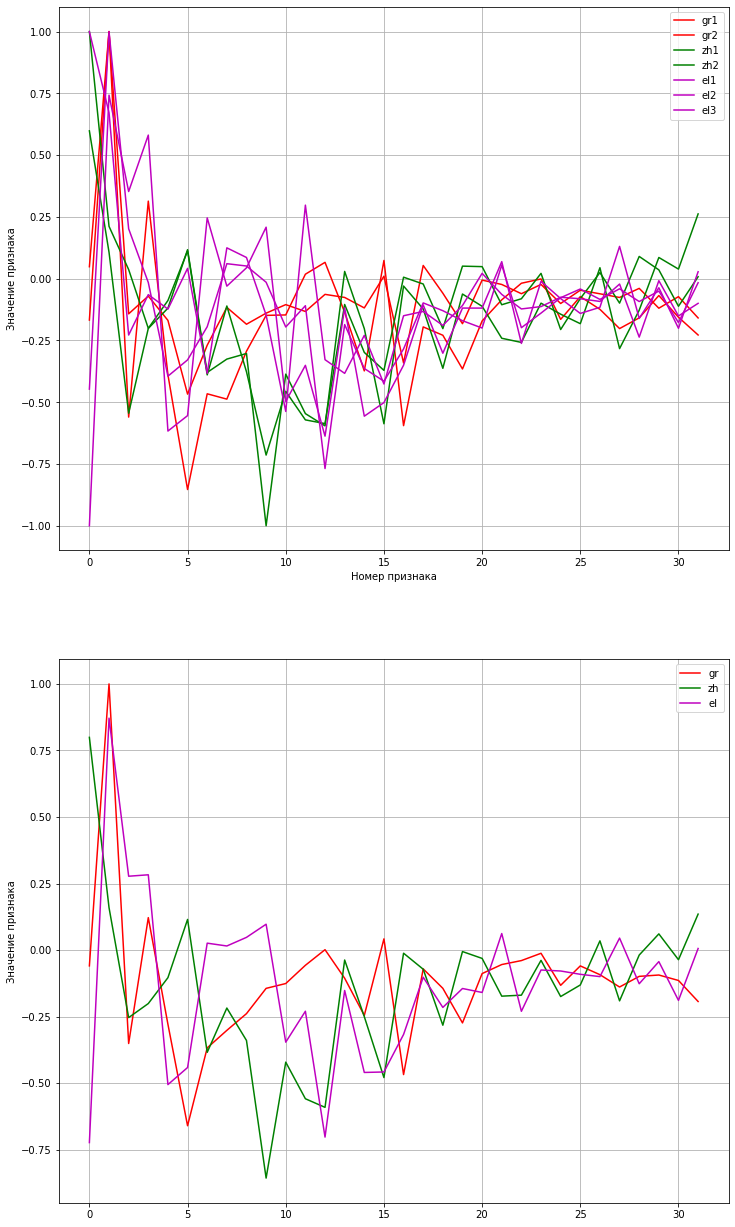

In [10]:
fig, ax = plt.subplots(2, 1, figsize=(12, 22))
ax[0].plot(df.t, df.gr1, 'r')
ax[0].plot(df.t, df.gr2, 'r')
ax[0].plot(df.t, df.zh1, 'g')
ax[0].plot(df.t, df.zh2, 'g')
ax[0].plot(df.t, df.el1, 'm')
ax[0].plot(df.t, df.el2, 'm')
ax[0].plot(df.t, df.el3, 'm')
ax[0].set_xlabel('Номер признака')
ax[0].set_ylabel('Значение признака')
ax[0].legend(['gr1', 'gr2', 'zh1', 'zh2', 'el1', 'el2', 'el3'])
ax[0].grid()

ax[1].plot(df.t, df.gr_mean, 'r')
ax[1].plot(df.t, df.zh_mean, 'g')
ax[1].plot(df.t, df.el_mean, 'm')
#ax[1].set_xlabel('Номер признака')
ax[1].set_ylabel('Значение признака')
ax[1].legend(['gr', 'zh', 'el'])
ax[1].grid()

In [11]:
print(lr.__version__)

0.8.0
